Source: http://www.mickaellegal.com/blog/2014/1/30/how-to-build-a-recommender

This notebook will show some basic steps to create a simple book recommender system. The model will take as input a historic set of book ratings from multiple reviewers and a selected book. It then suggests what other book might be interesting. We find this in some online shops as well.

## Background on the Recommender System used

For recommender systems, three approaches exist:
- Collaborative filtering (Item bases or User based)
- Content based filtering
- Hybrid forms

We will use the Item-based Collaborative Filtering approach. We only need to determine for a given book how similar it is to other books and return the top most similar ones.

The whole process to build this recommender can be divided into three main steps:
1. Collect personal preferences
2. Find similarities
3. Calculate recommendations

## Collect personal preferences

First we need data. We will use an already cleansed dataset from Book-Crossing. So the hard work has been done. First we will inspect what kind of data we have and generate some insights.

In [42]:
# Import some important libraries
import pandas as pd
import numpy as np
import json
%matplotlib inline

Lets read-in the data and show the 5 rows to see how the data looks like.

In [2]:
data = pd.read_csv("/resources/data_books.csv", sep = ",", header=None,
                         names=['Reviewer', 'Book', 'Rating'])

# Let's see what the dataframe looks like
data.head()

,Reviewer,Book,Rating
0,276726,Rites of Passage,5
1,276729,Help!: Level 1,3
2,276729,The Amsterdam Connection : Level 4 (Cambridge ...,6
3,276744,A Painted House,7
4,276747,Little Altars Everywhere,9


What is the size of the data?

In [3]:
# Get the dimensions of the dataframe
dim = data.shape
print "There are %d rows in this dataframe and %d features." %(dim[0], dim[1])

There are 383852 rows in this dataframe and 3 features.


## Get some insights

So we have about 400.000 ratings. But how many unique books and reviewers do we have?

In [4]:
print "%d unique books." %pd.unique(data[['Book']].values.ravel()).size

135394 unique books.


In [5]:
print "%d unique reviewers." %pd.unique(data[['Reviewer']].values.ravel()).size

68092 unique reviewers.


Determine the amount of reviews per book and show the top 20.

In [6]:
# Top 20 most reviewed books 
top_books = pd.value_counts(data.Book)
top_books.head(20)

The Lovely Bones: A Novel                                           707
Wild Animus                                                         581
The Da Vinci Code                                                   494
The Secret Life of Bees                                             406
The Nanny Diaries: A Novel                                          393
The Red Tent (Bestselling Backlist)                                 383
Bridget Jones's Diary                                               377
A Painted House                                                     366
Life of Pi                                                          336
Harry Potter and the Chamber of Secrets (Book 2)                    326
Divine Secrets of the Ya-Ya Sisterhood: A Novel                     323
Angels &amp                                                         317
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))    315
The Summons                                                     

Lets show a graph of the top 1000 most reviewed books.

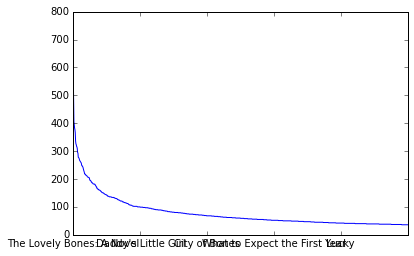

In [43]:
top_books['row'] = range(1, len(top_books) + 1)
top_books[:1000].plot(x=top_books.row)

Now determine how many reviews each user has given.

In [11]:
# Top Reviewers
top_reviewers = pd.value_counts(data.Reviewer)
top_reviewers.head(20)

11676     6943
98391     5691
189835    1899
153662    1845
23902     1180
235105    1020
76499     1012
171118     962
16795      959
248718     941
56399      838
197659     781
35859      777
185233     698
95359      606
114368     603
158295     567
101851     563
177458     524
204864     504
Name: Reviewer, dtype: int64

Wow, there are people that give almost 7000 reviews! Hmmm, something to investigate later.

# Finding Similarities

Based on the ratings we need to determine the similarity between books. Mostly distance or correlation is used for this. But there are different ways to calculate this.

The **Manhattan-distance** which is the sum of the absolute differences along the chosen axis. e.g. when plotted on a graph its the sum of delta y and delta x.

The **Euclidean-distance** which is the most intuitive one and calculated by pythagoras theorem.

The **Pearson-correlation** which is a more complex one. It looks at how two variables changes together relatively to their individuals changes.

The **Cosine-similarity** which measures the distance by calculating the angle from the origin.

In this execise we will use the **Pearson-correlation** because it tends to perform better for unbalanced ratings; e.g. some users only give bad reviews and others mostly positive reviews.

We start small. Get for all the reviewers that have reviewed two specific books. Then get all the books they also reviewed.

In [4]:
# Picking 2 books 
book_1, book_2 = "Harry Potter and the Chamber of Secrets (Book 2)", "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"

# Getting all the reviewers for these books
book_1_reviewers = data[data.Book == book_1].Reviewer
book_2_reviewers = data[data.Book == book_2].Reviewer

In [5]:
# Check if there are any common reviewers
common_reviewers = set(book_1_reviewers).intersection(book_2_reviewers)

print "%d people have reviewed these 2 books" % len(common_reviewers)

# Checking the table with only the common reviewers
list_common_reviewers = []

for i in common_reviewers:
    list_common_reviewers.append(i)

common_reviewers_only = data[data.Reviewer.isin(list_common_reviewers)]

common_reviewers_only.head(10)

92 people have reviewed these 2 books


,Reviewer,Book,Rating
14299,10560,The Death of Vishnu: A Novel,8
14300,10560,The Last Report on the Miracles at Little No H...,8
14301,10560,Mirror Mirror: A Novel,9
14302,10560,The Hidden Life of Otto Frank,10
14303,10560,"The Lady, the Chef, and the Courtesan",5
14304,10560,Tracks RI,6
14305,10560,My Antonia (Twentieth-Century Classics),6
14306,10560,A Mind of Its Own: A Cultural History of the P...,7
14307,10560,"Mary, Called Magdalene",7
14308,10560,The Red Tent (Bestselling Backlist),9


In [6]:
# Let's create a function that collect the reviews of our common reviewers
def get_book_reviews(title, common_reviewers):
    mask = (data.Reviewer.isin(common_reviewers)) & (data.Book==title)
    reviews = data[mask].sort_values('Reviewer')
    reviews = reviews[reviews.Reviewer.duplicated()==False]
    return reviews

## Calculating the correlation

In [7]:
# Importing the scipy library to measure the pearson correlation coefficient
from scipy.stats.stats import pearsonr

def calculate_correlation(book1, book2):
    # We start by finding the common reviewers
    book_1_reviewers = data[data.Book == book1].Reviewer
    book_2_reviewers = data[data.Book == book2].Reviewer
    common_reviewers = set(book_1_reviewers).intersection(book_2_reviewers)

    # Then we look for the reviews given by common reviewers
    book_1_reviews = get_book_reviews(book1, common_reviewers)
    book_2_reviews = get_book_reviews(book2, common_reviewers)
    
    # Calculate the Pearson Correlation Score
    return pearsonr(book_1_reviews.Rating, book_2_reviews.Rating)[0]

# Print the correlation score
calculate_correlation(book_1,book_2)

0.86964736645336571

## Let's expand the idea to a larger set of books

In [8]:
# As I want to avoid dealing with a huge sparse matrix, I will only select the top most reviewed books for our example 

most_reviewed_books = pd.DataFrame({'count' : data.groupby(["Book"]).size()})\
                                    .reset_index().sort_values(['count'],ascending = False)

most_reviewed_books.head(20)

,Book,count
110079,The Lovely Bones: A Novel,707
132075,Wild Animus,581
102555,The Da Vinci Code,494
116044,The Secret Life of Bees,406
111800,The Nanny Diaries: A Novel,393
114808,The Red Tent (Bestselling Backlist),383
15736,Bridget Jones's Diary,377
3064,A Painted House,366
60614,Life of Pi,336
45326,Harry Potter and the Chamber of Secrets (Book 2),326


In [9]:
# Getting the list of the most reviewed book

top_books = []

for i in most_reviewed_books.Book[0:13]:
    top_books.append(i)

    
# calculate the correlation for our top books
correlation_coefficient = []

for book1 in top_books:
    print "Calculating the correlations for:", book1
    for book2 in top_books:
        if book1 != book2:
            row = [book1, book2] + [calculate_correlation(book1, book2)]
            correlation_coefficient.append(row)

Calculating the correlations for: The Lovely Bones: A Novel
Calculating the correlations for: Wild Animus
Calculating the correlations for: The Da Vinci Code
Calculating the correlations for: The Secret Life of Bees
Calculating the correlations for: The Nanny Diaries: A Novel
Calculating the correlations for: The Red Tent (Bestselling Backlist)
Calculating the correlations for: Bridget Jones's Diary
Calculating the correlations for: A Painted House
Calculating the correlations for: Life of Pi
Calculating the correlations for: Harry Potter and the Chamber of Secrets (Book 2)
Calculating the correlations for: Divine Secrets of the Ya-Ya Sisterhood: A Novel
Calculating the correlations for: Angels &amp
Calculating the correlations for: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))


In [10]:
# Let's look at what the table of correlation looks like
cols = ["Book_1", "Book_2", "Correlation"]
correlation_coefficient = pd.DataFrame(correlation_coefficient, columns=cols).sort_values('Correlation')
correlation_coefficient.head(10)

,Book_1,Book_2,Correlation
25,The Da Vinci Code,Wild Animus,-0.580228
13,Wild Animus,The Da Vinci Code,-0.580228
61,The Red Tent (Bestselling Backlist),Wild Animus,-0.487857
16,Wild Animus,The Red Tent (Bestselling Backlist),-0.487857
49,The Nanny Diaries: A Novel,Wild Animus,-0.424865
15,Wild Animus,The Nanny Diaries: A Novel,-0.424865
97,Life of Pi,Wild Animus,-0.409176
19,Wild Animus,Life of Pi,-0.409176
21,Wild Animus,Divine Secrets of the Ya-Ya Sisterhood: A Novel,-0.322301
121,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Wild Animus,-0.322301


In [11]:
# Let's clean up some of the titles
correlation_coefficient= correlation_coefficient.replace(["The Red Tent (Bestselling Backlist)", "Harry Potter and the Chamber of Secrets (Book 2)",
                                 "Angels &amp", "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"],
                                ["The Red Tent", "Harry Potter and the Chamber of Secrets", "Angels & Demons",
                                 "Harry Potter and the Sorcerer's Stone"])

In [12]:
def calc_correlation(corr, book1, book2):
    mask = (corr.Book_1==book1) & (corr.Book_2==book2)
    row = corr[mask]
    corr = row
    return corr.sum(axis=1).tolist()[0]

In [13]:
calc_correlation(correlation_coefficient,"Harry Potter and the Sorcerer's Stone", "The Red Tent")

0.35326135281447008

## Finding similar books to 'Harry Potter and the Sorcerer's Stone'

In [14]:
# Making sure that the top books is also updated with the new titles
top_books[5] = "The Red Tent"
top_books[9] = "Harry Potter and the Chamber of Secrets"
top_books[11] = "Angels & Demons"
top_books[12] = "Harry Potter and the Sorcerer's Stone"

print top_books

['The Lovely Bones: A Novel', 'Wild Animus', 'The Da Vinci Code', 'The Secret Life of Bees', 'The Nanny Diaries: A Novel', 'The Red Tent', "Bridget Jones's Diary", 'A Painted House', 'Life of Pi', 'Harry Potter and the Chamber of Secrets', 'Divine Secrets of the Ya-Ya Sisterhood: A Novel', 'Angels & Demons', "Harry Potter and the Sorcerer's Stone"]


In [15]:
# Finding the top recommendation for Harry Potter
my_book = "Harry Potter and the Sorcerer's Stone"

results = []
for b in top_books:
    if my_book!=b:
        results.append((my_book, b, calc_correlation(correlation_coefficient, my_book, b)))
sorted(results, key=lambda x: x[2], reverse=True)

[("Harry Potter and the Sorcerer's Stone",
  'Harry Potter and the Chamber of Secrets',
  0.86964736645336571),
 ("Harry Potter and the Sorcerer's Stone",
  'The Nanny Diaries: A Novel',
  0.53751347372691571),
 ("Harry Potter and the Sorcerer's Stone", 'Wild Animus', 0.48412291827592707),
 ("Harry Potter and the Sorcerer's Stone",
  'Angels & Demons',
  0.45363235436327737),
 ("Harry Potter and the Sorcerer's Stone",
  'The Red Tent',
  0.35326135281447008),
 ("Harry Potter and the Sorcerer's Stone",
  'Divine Secrets of the Ya-Ya Sisterhood: A Novel',
  0.28960942612539081),
 ("Harry Potter and the Sorcerer's Stone",
  'A Painted House',
  0.26363525200414828),
 ("Harry Potter and the Sorcerer's Stone",
  'The Lovely Bones: A Novel',
  0.18557232038403582),
 ("Harry Potter and the Sorcerer's Stone",
  "Bridget Jones's Diary",
  0.026519482723970682),
 ("Harry Potter and the Sorcerer's Stone", 'The Secret Life of Bees', 0.0),
 ("Harry Potter and the Sorcerer's Stone",
  'The Da Vinci 

In [18]:
def predict(my_book):
    results = []
    for other_book in top_books:
        if my_book != other_book:
            correlation = calc_correlation(correlation_coefficient, my_book, other_book)
            results.append((my_book, other_book, correlation)) 
    return sorted(results, key=lambda x: x[2], reverse=True)

Now we can test for a given book, what other suggestions we should consider.

In [19]:
predict("Harry Potter and the Sorcerer's Stone")

[("Harry Potter and the Sorcerer's Stone",
  'Harry Potter and the Chamber of Secrets',
  0.86964736645336571),
 ("Harry Potter and the Sorcerer's Stone",
  'The Nanny Diaries: A Novel',
  0.53751347372691571),
 ("Harry Potter and the Sorcerer's Stone", 'Wild Animus', 0.48412291827592707),
 ("Harry Potter and the Sorcerer's Stone",
  'Angels & Demons',
  0.45363235436327737),
 ("Harry Potter and the Sorcerer's Stone",
  'The Red Tent',
  0.35326135281447008),
 ("Harry Potter and the Sorcerer's Stone",
  'Divine Secrets of the Ya-Ya Sisterhood: A Novel',
  0.28960942612539081),
 ("Harry Potter and the Sorcerer's Stone",
  'A Painted House',
  0.26363525200414828),
 ("Harry Potter and the Sorcerer's Stone",
  'The Lovely Bones: A Novel',
  0.18557232038403582),
 ("Harry Potter and the Sorcerer's Stone",
  "Bridget Jones's Diary",
  0.026519482723970682),
 ("Harry Potter and the Sorcerer's Stone", 'The Secret Life of Bees', 0.0),
 ("Harry Potter and the Sorcerer's Stone",
  'The Da Vinci 

In [2]:
from IPython.html import widgets
from IPython.display import display, clear_output
checkbox = widgets.Checkbox(description = "Checkbox", value = False)

button = widgets.Button(description = 'Click me')
display(checkbox)
button